In [1]:
%load_ext autoreload

In [ ]:
%autoreload 2

from hydra import compose, initialize
import matplotlib.pyplot as plt
import os
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu, pearsonr
from statsmodels.tsa.stattools import acf
from tqdm.auto import tqdm

from UniversalUnconsciousness.data_utils import *
from UniversalUnconsciousness.plot_utils import *

plt.style.use('UniversalUnconsciousness.sci_style')
load_font()

In [3]:
with initialize(version_base="1.3", config_path="../../UniversalUnconsciousness/DeLASE_analysis/conf"):
    cfg = compose(config_name="config")

In [4]:
# cfg.params.low_pass = 0.1
# cfg.params.high_pass = 4

# cfg.params.low_pass = 80
# cfg.params.high_pass = 30

cfg.params.low_pass = None
cfg.params.high_pass = None

cfg.params.stride = 15
cfg.params.window = 15

In [5]:
anesthetic_agent_list = cfg.plotting.anesthetic_agent_list
img_save_dir = cfg.plotting.img_save_dir
curve_colors = cfg.plotting.curve_colors
loc_roc_colors = cfg.plotting.loc_roc_colors
os.makedirs(img_save_dir, exist_ok=True)

In [6]:
agent_data = get_agent_data(cfg, use_individiual_areas=False, verbose=False)

  0%|          | 0/3 [00:00<?, ?it/s]

Only 1 valid windows could be found for section 'awake lever1' with times [np.float64(-36.120676111111116), np.float64(-26.045618333333337)]


In [7]:
data_dir = os.path.join(os.path.dirname(cfg.plotting.img_save_dir), 'var_data')
os.makedirs(data_dir, exist_ok=True)
var_data_all = {}
for data_class, agent in anesthetic_agent_list:
    var_data_all[(data_class, agent)] = {}
    agent_data_dir = os.path.join(data_dir, f"{agent}")
    os.makedirs(agent_data_dir, exist_ok=True)
    cfg.params.data_class = data_class
    for monkey in agent_data[(data_class, agent)]['session_lists']:
        var_data_all[(data_class, agent)][monkey] = {}
        sessions_to_use = agent_data[(data_class, agent)]['session_lists'][monkey]['high']
        for session in sessions_to_use:
            file_path = os.path.join(agent_data_dir, f"{session}_var_data.pkl")
            if os.path.exists(file_path):
                print(f"Skipping {session} because it already exists")
                var_data_all[(data_class, agent)][monkey][session] = pd.read_pickle(file_path)
                continue
            df = agent_data[(data_class, agent)]['delase_results'][session]['all']

            if cfg.params.data_class == 'anesthesiaLvrOdd':
                session_file = h5py.File(os.path.join(cfg.params.all_data_dir, data_class, 'mat', f"{session}.mat"))
            else:
                session_file = h5py.File(os.path.join(cfg.params.all_data_dir, 'anesthesia', 'mat', data_class, f"{session}.mat"))

            lfp = TransposedDatasetView(session_file['lfp']).transpose()
            electrodes_to_use = np.setdiff1d(np.arange(lfp.shape[1]), agent_data[(data_class, agent)]['noise_filter_info'][session]['bad_electrodes'])
            dt = session_file['lfpSchema']['smpInterval'][0, 0]

            var_data_rows = []
            for i, row in tqdm(df.iterrows(), total=len(df)):
                window_lfp = lfp[int(row.window_start/dt):int(row.window_end/dt), electrodes_to_use]
                window_lfp
                A = np.linalg.lstsq(window_lfp[:-1], window_lfp[1:], rcond=1e-13)[0].T

                window_lfp_small = window_lfp[:500]
                A_small = np.linalg.lstsq(window_lfp_small[:-1], window_lfp_small[1:], rcond=1e-13)[0].T
                eigvals_A = np.linalg.eigvals(A)
                eigvals_A_small = np.linalg.eigvals(A_small)

                var_data_rows.append({
                    'window_start': row.window_start,
                    'window_end': row.window_end,
                    'eigvals_A': eigvals_A,
                    'stability_params_A': np.sort(np.log(np.abs(eigvals_A))/dt)[::-1],
                    'eigvals_A_small': eigvals_A_small,
                    'stability_params_A_small': np.sort(np.log(np.abs(eigvals_A_small))/dt)[::-1],
                })
            
            var_data_df = pd.DataFrame(var_data_rows)

            pd.to_pickle(var_data_df, file_path)
            var_data_all[(data_class, agent)][monkey][session] = var_data_df

Skipping Mary-Anesthesia-20160818-02 because it already exists
Skipping Mary-Anesthesia-20160822-02 because it already exists
Skipping Mary-Anesthesia-20160809-01 because it already exists
Skipping Mary-Anesthesia-20160908-02 because it already exists
Skipping Mary-Anesthesia-20160902-02 because it already exists
Skipping Mary-Anesthesia-20160912-02 because it already exists
Skipping Mary-Anesthesia-20160916-02 because it already exists
Skipping Mary-Anesthesia-20160826-02 because it already exists
Skipping Mary-Anesthesia-20160914-02 because it already exists
Skipping Mary-Anesthesia-20160831-02 because it already exists
Skipping MrJones-Anesthesia-20160125-01 because it already exists
Skipping MrJones-Anesthesia-20160210-01 because it already exists
Skipping MrJones-Anesthesia-20160121-01 because it already exists
Skipping MrJones-Anesthesia-20160301-01 because it already exists
Skipping MrJones-Anesthesia-20160105-01 because it already exists
Skipping MrJones-Anesthesia-20160201-01 

In [8]:
top_percent = 0.1
dose = 'high'
area = 'all'

In [9]:
var_results = {}
for (data_class, agent), data_dict in agent_data.items():
    var_results[(data_class, agent)] = {}
    for monkey in var_data_all[(data_class, agent)]:
        var_results[(data_class, agent)][monkey] = {}
        for session in var_data_all[(data_class, agent)][monkey]:
            var_results[(data_class, agent)][session] = {'all': var_data_all[(data_class, agent)][monkey][session]}

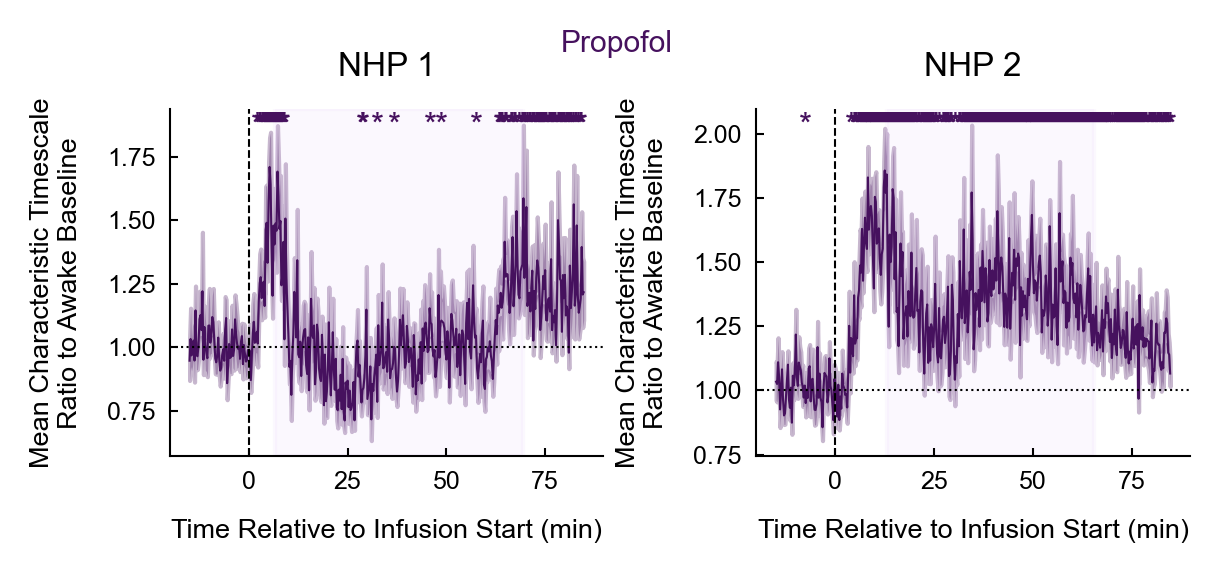

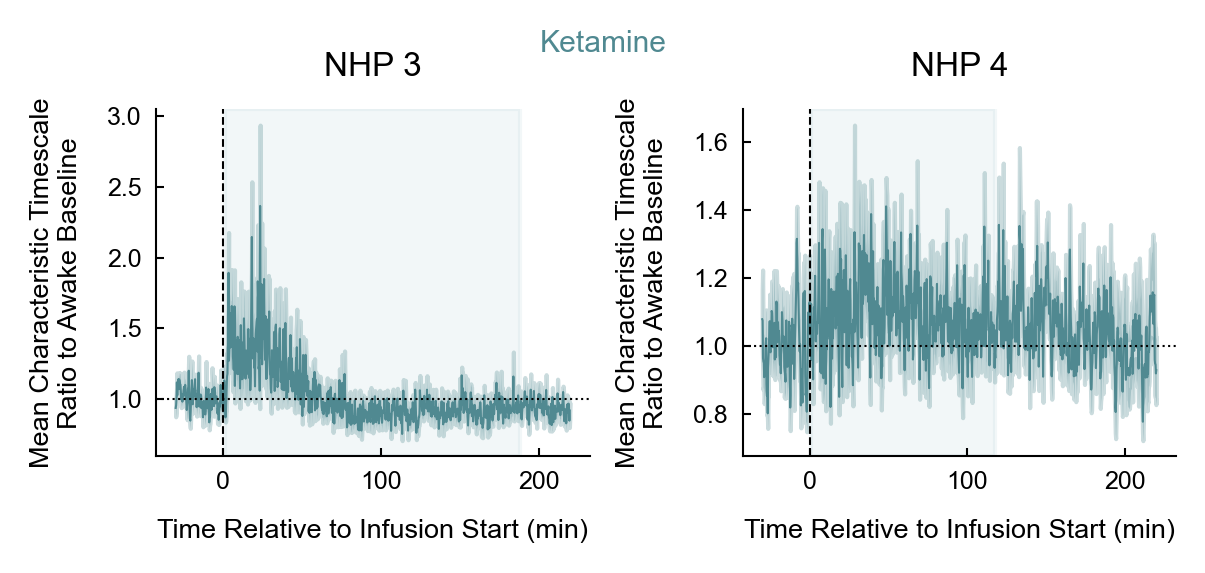

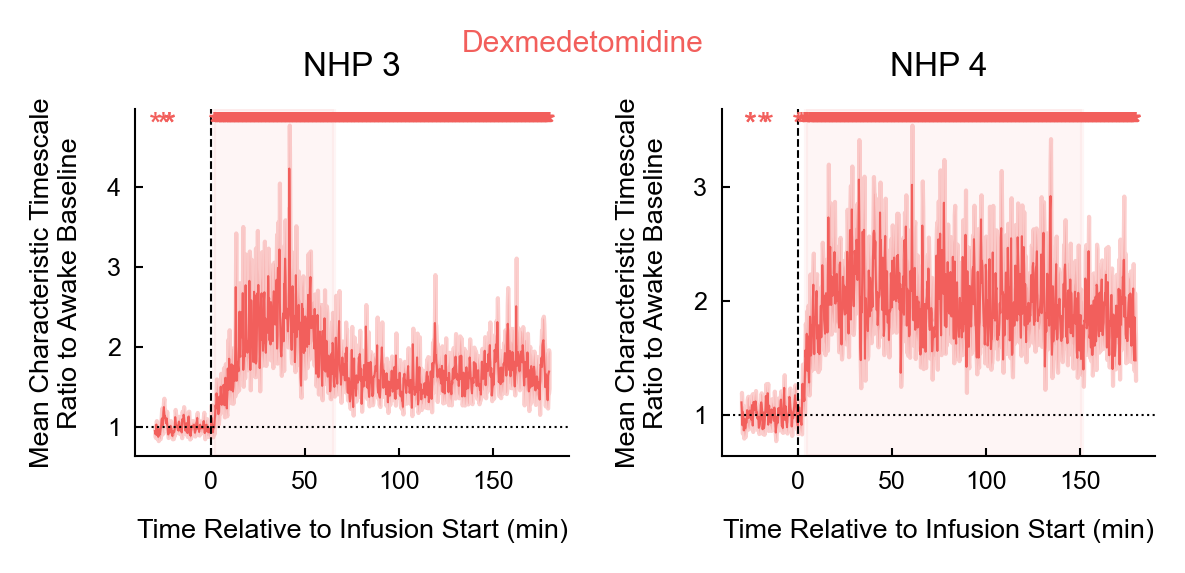

In [10]:
plot_data = {}
data_type = 'var_small'
# data_type = 'var'
for (data_class, agent), data_dict in agent_data.items():
    # area = 'vlPFC' if agent == 'propofol' else 'vlPFC-L'
    # area = 'FEF' if agent == 'propofol' else 'vlPFC-R'
    # area = '7b' if agent == 'propofol' else 'dlPFC-R'
    # area = 'CPB' if agent == 'propofol' else 'dlPFC-L'
    if agent == 'propofol':
        plot_range = (-15, 85)
    elif agent == 'ketamine':
        plot_range = (-30, 220)
    else:
        plot_range = (-30, 180)
    if dose == 'high':
        save_path = os.path.join(img_save_dir, f"{agent}_{data_type}_timescales_grouped_filter_{cfg.params.low_pass}_{cfg.params.high_pass}_{area}_window_{cfg.params.window}_stride_{cfg.params.stride}.pdf")
    else:
        save_path = os.path.join(img_save_dir, f"{agent}_{data_type}_timescales_grouped_low_dose_filter_{cfg.params.low_pass}_{cfg.params.high_pass}_{area}_window_{cfg.params.window}_stride_{cfg.params.stride}.pdf")
    cfg.params.data_class = data_class
    plot_data[(data_class, agent)] = plot_session_stability_grouped(
        cfg, 
        agent, 
        data_dict['session_lists'], 
        var_results[(data_class, agent)], 
        data_dict['locs'], 
        data_dict['rocs'], 
        data_dict['ropaps'],
        timescales=True,
        plot_range=plot_range, 
        top_percent=top_percent, 
        curve_colors=curve_colors, 
        loc_roc_colors=loc_roc_colors, 
        figsize=(4, 2),
        dose=dose,
        save_path=save_path,
        verbose=True,
        area=area,
        return_data=True,
        data_type=data_type
    )

propofol high unconscious-awake: 0.0244140625
propofol high unconscious-awake: 0.00048828125
ketamine high unconscious-awake: 0.00390625
ketamine high recovery-awake: 0.125
ketamine high unconscious-awake: 0.0390625
ketamine high recovery-awake: 0.90234375
dexmedetomidine high unconscious-awake: 0.00390625
dexmedetomidine high unconscious-awake: 0.00390625


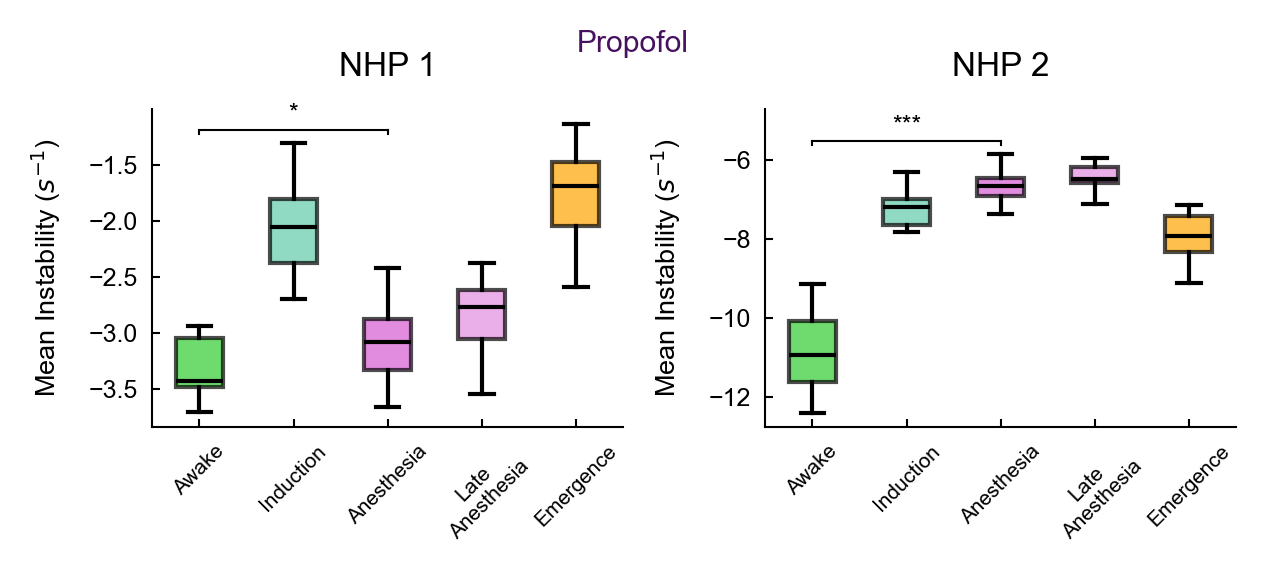

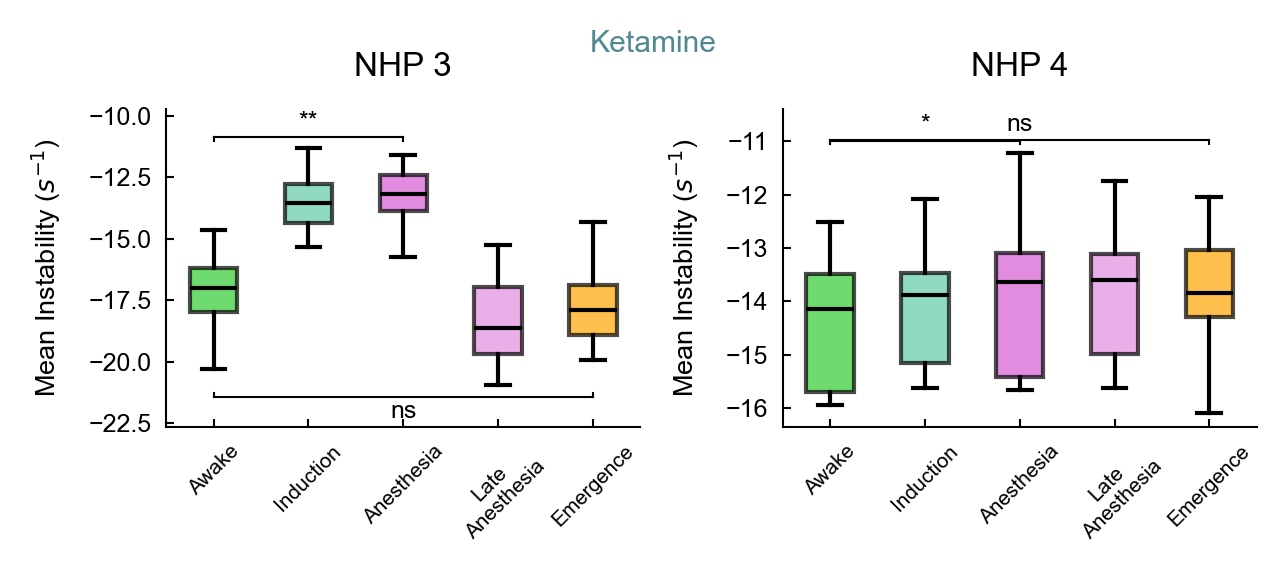

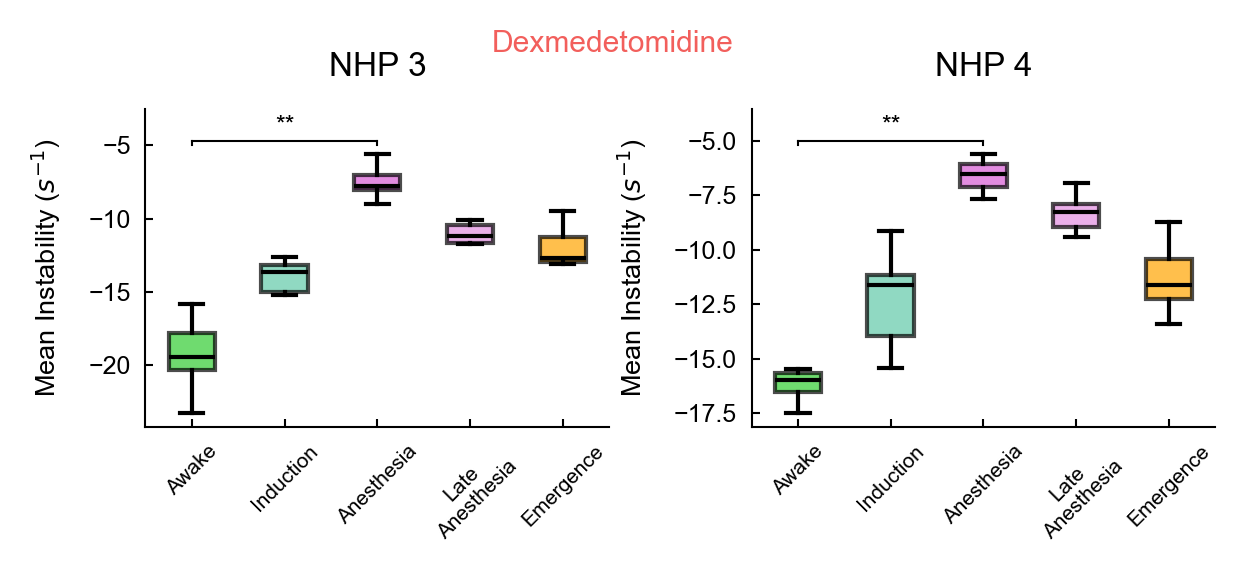

In [12]:
top_percent = 0.1
area = 'all'
section_means = {}
data_type = 'var_small'
for (data_class, agent), data_dict in agent_data.items():
    # area = 'vlPFC' if agent == 'propofol' else 'vlPFC-L'
    # area = 'FEF' if agent == 'propofol' else 'vlPFC-R'
    # area = '7b' if agent == 'propofol' else 'dlPFC-R'
    # area = 'CPB' if agent == 'propofol' else 'dlPFC-L'
    if dose == 'high':
        save_path = os.path.join(img_save_dir, f"{agent}_{data_type}_section_stability_boxes_filter_{cfg.params.low_pass}_{cfg.params.high_pass}_{area}_window_{cfg.params.window}_stride_{cfg.params.stride}.pdf")
    else:
        save_path = os.path.join(img_save_dir, f"{agent}_{data_type}_section_stability_boxes_low_dose_filter_{cfg.params.low_pass}_{cfg.params.high_pass}_{area}_window_{cfg.params.window}_stride_{cfg.params.stride}.pdf")
    cfg.params.data_class = data_class
    section_means[(data_class, agent)] = plot_section_stability_boxes(
        cfg, 
        agent, 
        data_dict['session_lists'], 
        var_results[(data_class, agent)], 
        top_percent=top_percent,
        curve_colors=curve_colors,
        figsize=None,
        dose=dose,
        save_path=save_path,
        section_info_type='plot',
        verbose=False,
        area=area,
        data_type=data_type
    )

propofol high unconscious-awake: 0.0244140625
propofol high unconscious-awake: 0.00048828125
ketamine high unconscious-awake: 0.00390625
ketamine high recovery-awake: 0.125
ketamine high unconscious-awake: 0.0390625
ketamine high recovery-awake: 0.90234375
dexmedetomidine high unconscious-awake: 0.00390625
dexmedetomidine high unconscious-awake: 0.00390625


{'propofol': {'Mary': {'high': {'Mary-Anesthesia-20160818-02': {'Awake': np.float64(-2.935585281690904),
     'Induction': np.float64(-1.7611076840061402),
     'Anesthesia': np.float64(-2.4216115718504714),
     'Late Anesthesia': np.float64(-1.7906559266014426),
     'Emergence': np.float64(-1.695604888832383)},
    'Mary-Anesthesia-20160822-02': {'Awake': np.float64(-3.090378983677531),
     'Induction': np.float64(-1.3032208524519622),
     'Anesthesia': np.float64(-2.9075422452823743),
     'Late Anesthesia': np.float64(-2.751867847642412),
     'Emergence': np.float64(-1.4635484986635623)},
    'Mary-Anesthesia-20160809-01': {'Awake': np.float64(-3.0238770692718515),
     'Induction': np.float64(-1.453377392066497),
     'Anesthesia': np.float64(-2.502159300335441),
     'Late Anesthesia': np.float64(-2.644409904402922),
     'Emergence': np.float64(-1.1317198365049022)},
    'Mary-Anesthesia-20160908-02': {'Awake': np.float64(-3.455383065025752),
     'Induction': np.float64(-2.

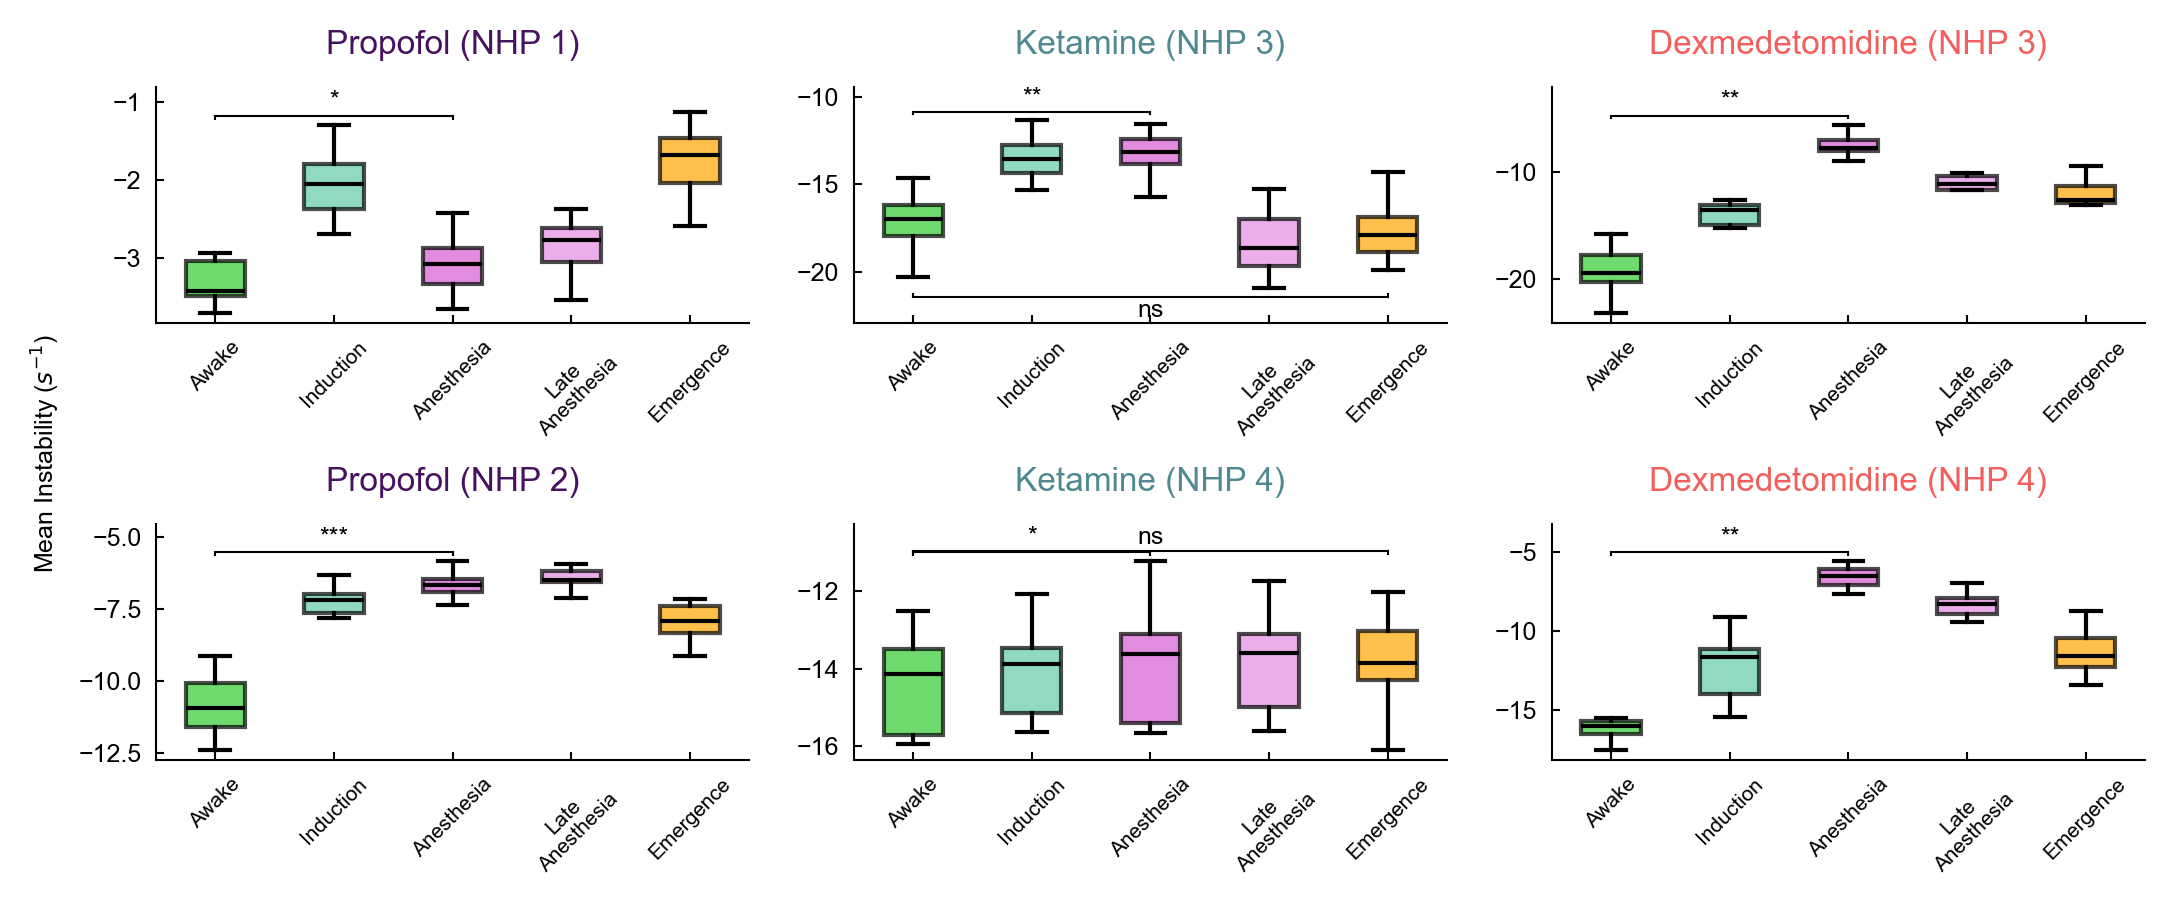

In [23]:
data_class_by_agent = {
    'propofol': 'propofolPuffTone',
    'ketamine': 'anesthesiaLvrOdd',
    'dexmedetomidine': 'anesthesiaLvrOdd',
}

data_type = 'var_small'

plot_section_stability_boxes_grid(
    cfg=cfg,
    agent_data=agent_data,
    results_by_agent=var_results,
    data_class_by_agent=data_class_by_agent,
    top_percent=top_percent,
    curve_colors=curve_colors,
    figsize=(7, 3),
    dose=dose,
    save_path=os.path.join(
        img_save_dir,
        'supp',
        f"grid_{data_type}_{dose}_filter_{cfg.params.low_pass}_{cfg.params.high_pass}_{area}_window_{cfg.params.window}_stride_{cfg.params.stride}.pdf"
    ),
    section_info_type='plot',
    verbose=False,
    area=area,
    data_type=data_type
)